In [1]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import math
import pyflagser
import statistics
import sys
import pickle
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

In [2]:
G=nx.read_gml("Fully Observable/37busEx.gml")
A = nx.to_numpy_array(G)
N=list(G.nodes)
E=list(G.edges)
with open('Fully Observable/fullanomalydataset.pkl', 'rb') as g:
    P0Data = pickle.load(g)

In [8]:
N_Senario=len(P0Data)
Class=[]
for i in range(500):
    Class.append(P0Data[i]["Anomalous"])
print("Total number of scenario: ",len(Class))
i=0
l=0
m=0
while i < len(Class):
    if Class[i] == 'No':
        l=l+1
        Class[i] = 0
    if Class[i] == 'Yes':
        m=m+1
        Class[i] = 1
    i += 1
print("Number of Normal scenario: ",l)
print("Number of Anomalous scenario:",m)

Total number of scenario:  500
Number of Normal scenario:  249
Number of Anomalous scenario: 251


In [9]:
def Average(lst):
    return sum(lst) / len(lst)
def TimeSeries_Fe_24(TS_array, F_voltage):
    betti_0=[]
    for k in range(len(TS_array)):
        fec=[]
        AverageVoltage=[]
        Voltage=TS_array[k]
        for y in Voltage:
            AverageVoltage.append(Average(list(y)))
        #AverageVoltage = [i * 10 for i in AverageVoltage]
        for p in range(len(F_voltage)):
            n_active = np.where(np.array(AverageVoltage) > F_voltage[p])[0].tolist()
            Active_node=np.unique(n_active)
            if (len(Active_node)==0):
                fec.append(0)
            else:
                b=A[Active_node,:][:,Active_node]
                my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
                x = my_flag["betti"]
                fec.append(x[0])
            n_active.clear()
        betti_0.append(fec)
    return betti_0

def Make_Sum(Array):
    one_dim_array = []

    # Iterate through each row of the 2D array
    for row in Array:
        # Iterate through each element of the row
        for i, element in enumerate(row):
            # If the one-dimensional array is not large enough, extend it
            if len(one_dim_array) <= i:
                one_dim_array.append(element)
            else:
                # Add the element to the corresponding index of the one-dimensional array
                one_dim_array[i] += element
    return one_dim_array

def TimeSeries_Fe_BF(TS_branchFlow, F_flow):
    betti_0=[]
    for k in range(len(TS_branchFlow)):
        BranchFlow=[]
        Branch_Flow=TS_branchFlow[k]
        for j  in range(len(Branch_Flow)):
            BranchFlow.append(Branch_Flow[j][0])
        for p in range(len(F_flow)):
            n_active = np.where(np.array(BranchFlow) > F_flow[p])[0].tolist()
            Active_node=np.unique(n_active)
            if (len(Active_node)==0):
                betti_0.append(0)
            else:
                b=A[Active_node,:][:,Active_node]
                my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
                x = my_flag["betti"]
                betti_0.append(x[0])
            n_active.clear()
    return betti_0

In [10]:
F_voltage=[1.4,1.3,1.2,1.1,1.0,0.99,0.98,0.97,0.96,0.95,0.94,0.92,0.90,0.89,0.88,0.87,0.86,0.85]
Betti_0=[]
N_Senario=len(P0Data)
for i in range(N_Senario):
    print("\rProcessing file {} ({}%)".format(i, 100*i//(N_Senario-1)), end='', flush=True)
    TimeSeries_Voltage=P0Data[i]["TimeSeries_Voltage"]
    betti=TimeSeries_Fe_24(TimeSeries_Voltage, F_voltage)
    Betti=Make_Sum(betti)
    Betti_0.append(Betti)

Processing file 499 (100%)

In [59]:
Vol_fec =np.array(Betti_0)
n=len(Betti_0[0])

Feture=[]
for i in range(n):
    Feture.append("{}".format(i))

Vdata = pd.DataFrame(Vol_fec, columns =Feture) 
Vdata.insert(loc=n,column='Class',value=Class)
Vdata.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,Class
495,0,0,0,0,24,48,48,48,46,41,37,24,24,24,24,24,24,24,1
496,0,0,0,0,22,48,48,48,48,44,41,26,26,26,26,26,26,26,1
497,0,0,0,0,24,48,48,48,41,37,30,24,24,24,24,24,24,24,1
498,0,0,0,0,15,48,48,48,48,46,41,26,24,24,24,24,24,24,0
499,0,0,0,0,24,48,48,48,46,41,37,24,24,24,24,24,24,24,0


In [12]:
X=Betti_0
y=Class
X=np.array(X)
y=np.array(y)

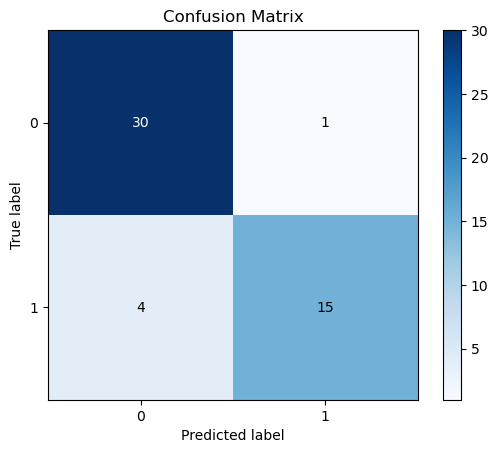

Accuracy: 90.0 %


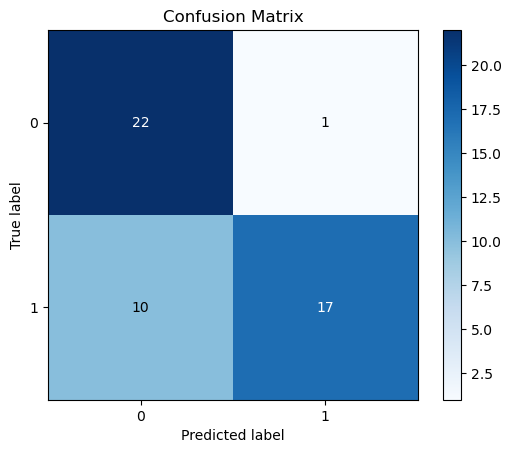

Accuracy: 78.0 %


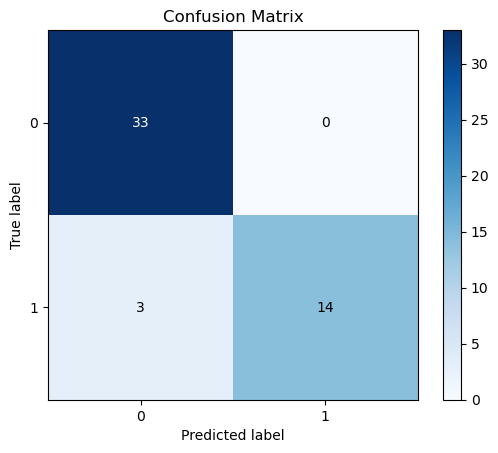

Accuracy: 94.0 %


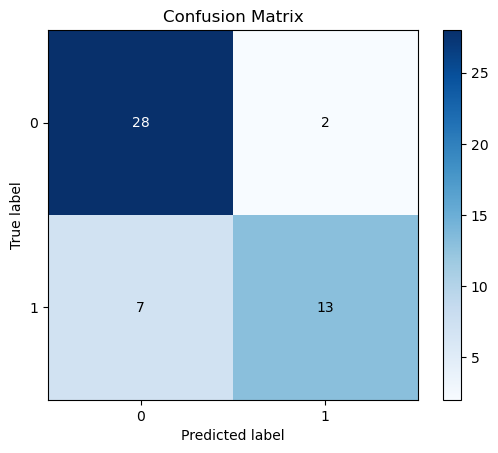

Accuracy: 82.0 %


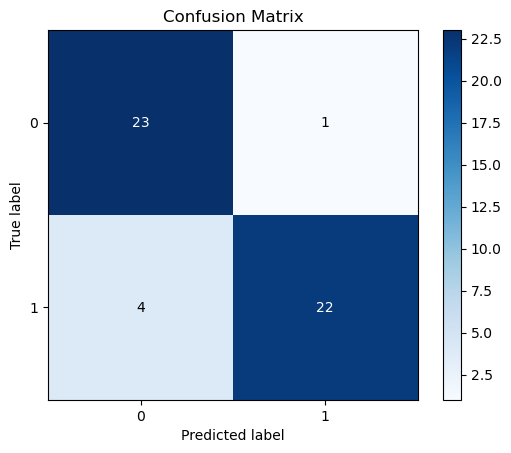

Accuracy: 90.0 %


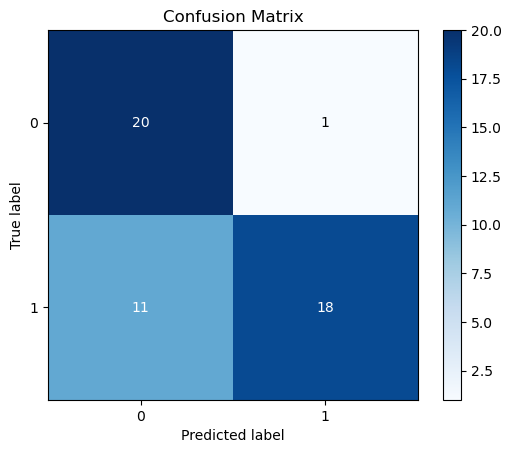

Accuracy: 76.0 %


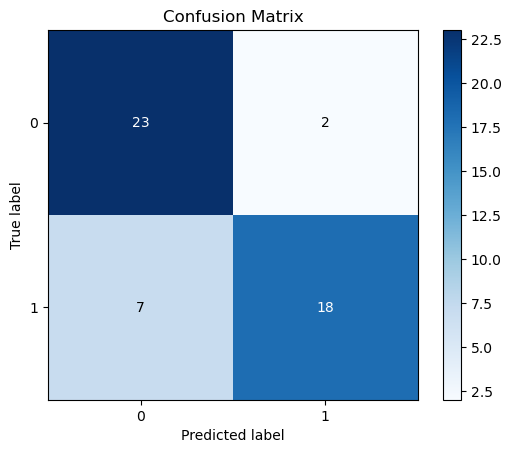

Accuracy: 82.0 %


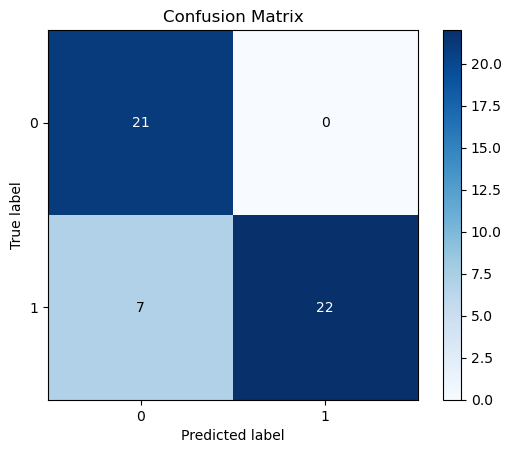

Accuracy: 86.0 %


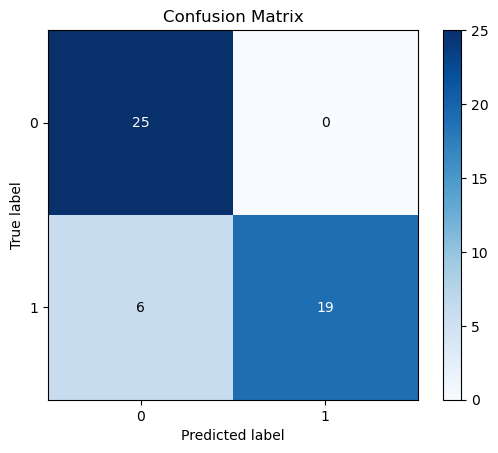

Accuracy: 88.0 %


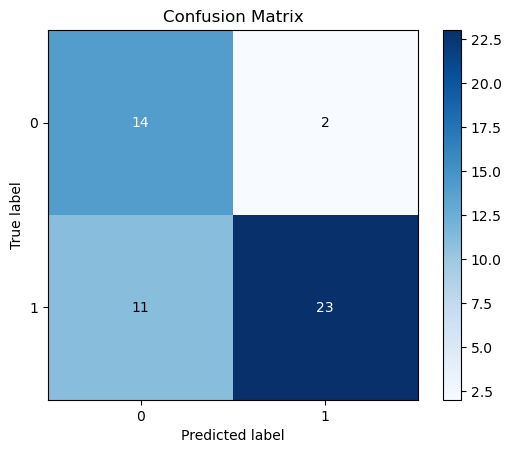

Accuracy: 74.0 %


In [13]:
# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):
    bst = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1,booster='gbtree')

    # Train the model
    bst.fit(X[train], y[train])
    # Evaluate the model
    y_pred=bst.predict(X[test])
    #Import scikit-learn metrics module for accuracy calculation
    
    skplt.metrics.plot_confusion_matrix(y[test], y_pred)
    #skplt.metrics.plot_roc(y_test, predicted_probas)
    #skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
    plt.show()
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

In [14]:
mean_value = statistics.mean(acc_per_fold)
std_dev = statistics.stdev(acc_per_fold)
print("Mean using XGBoost:", mean_value)
print("Standard Deviation:", std_dev)

Mean using XGBoost: 84.0
Standard Deviation: 6.666666666666667


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


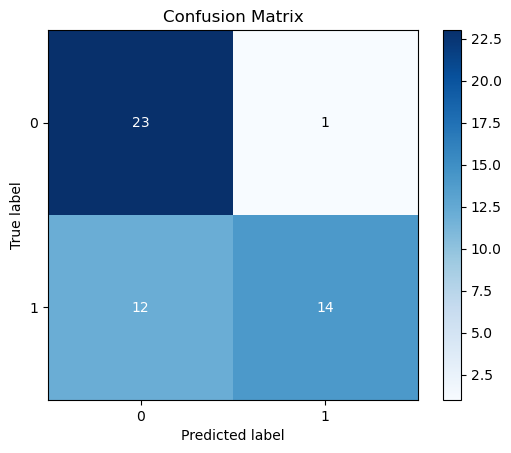

Accuracy: 74.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


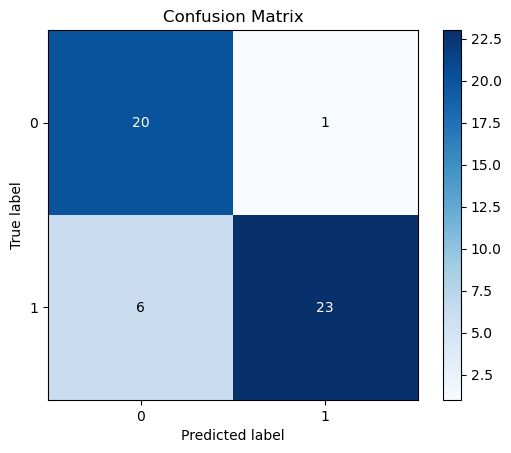

Accuracy: 86.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


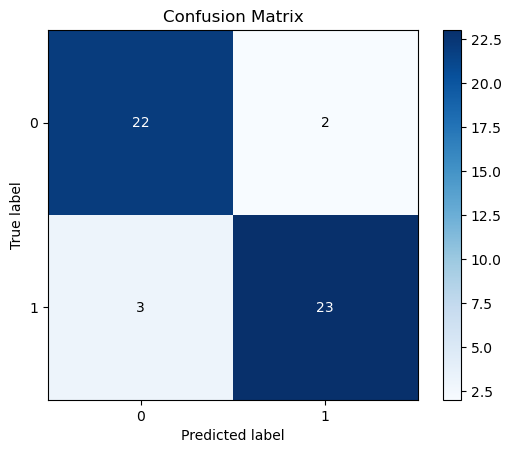

Accuracy: 90.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


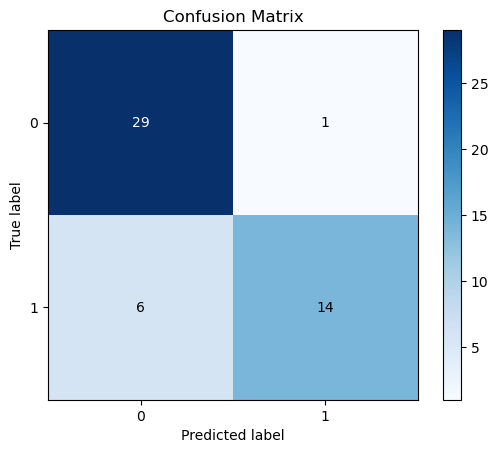

Accuracy: 86.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


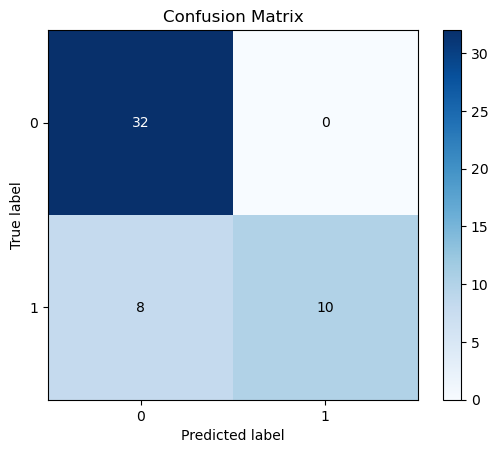

Accuracy: 84.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


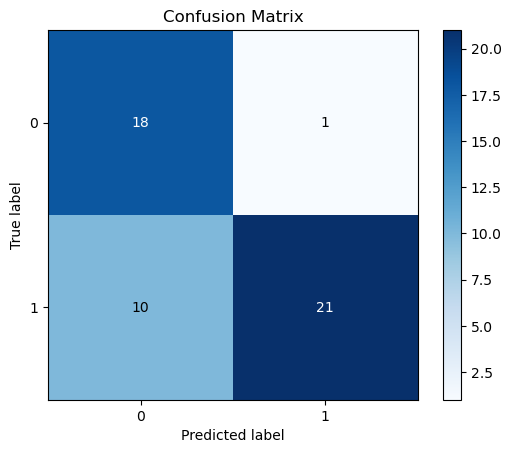

Accuracy: 78.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


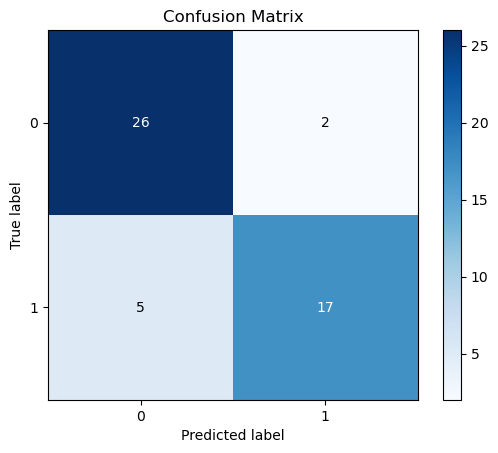

Accuracy: 86.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


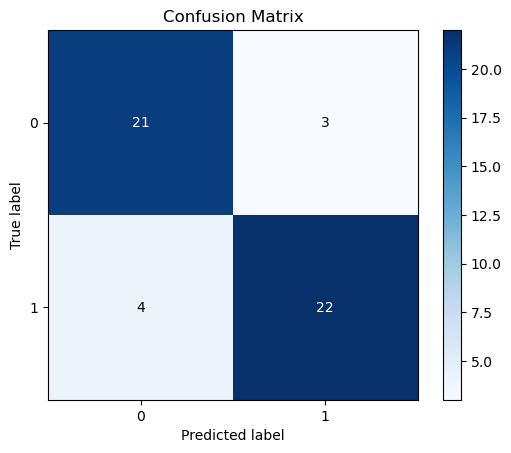

Accuracy: 86.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


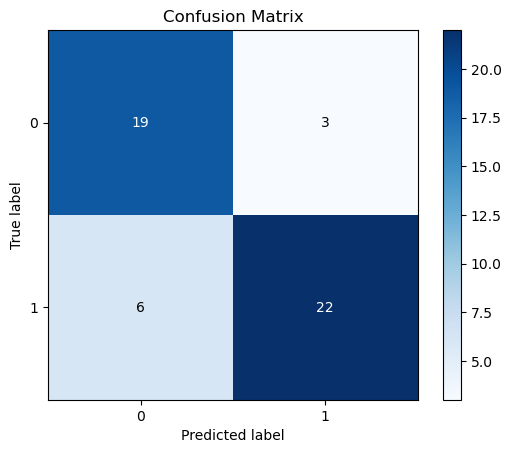

Accuracy: 82.0 %


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


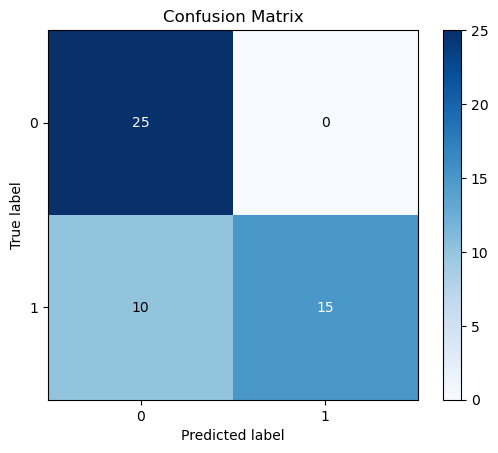

Accuracy: 80.0 %


In [60]:
# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):

    scaler = StandardScaler()  
    # Don't cheat - fit only on training data
    scaler.fit(X)  
    #X_train = scaler.transform(X_train)  
    # apply same transformation to test data
    #X_test = scaler.transform(X_test)  


    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,),activation='logistic', learning_rate='constant', learning_rate_init=0.001, random_state=1, max_iter=3000, warm_start=True)
    clf.fit(X[train], y[train])
    # Evaluate the model
    y_pred=clf.predict(X[test])



    skplt.metrics.plot_confusion_matrix(y[test], y_pred)
    #skplt.metrics.plot_roc(y_test, predicted_probas)
    #skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
    plt.show()
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

In [61]:
mean_value = statistics.mean(acc_per_fold)
std_dev = statistics.stdev(acc_per_fold)
print("Mean using MLP:", mean_value)
print("Standard Deviation:", std_dev)

Mean using MLP: 83.2
Standard Deviation: 4.732863826479693


In [57]:
from sklearn.ensemble import RandomForestClassifier
# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):
    clfR=RandomForestClassifier(n_estimators=200,max_depth=10,bootstrap=True)

    # Train the model
    clfR.fit(X[train], y[train])
    # Evaluate the model
    y_pred=clfR.predict(X[test])
    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

Accuracy: 88.0 %
Accuracy: 88.0 %
Accuracy: 86.0 %
Accuracy: 80.0 %
Accuracy: 88.0 %
Accuracy: 84.0 %
Accuracy: 78.0 %
Accuracy: 84.0 %
Accuracy: 90.0 %
Accuracy: 80.0 %


In [58]:
mean_value = statistics.mean(acc_per_fold)
std_dev = statistics.stdev(acc_per_fold)
print("Mean using Randomforest:", mean_value)
print("Standard Deviation:", std_dev)

Mean using Randomforest: 84.6
Standard Deviation: 4.115013163202924
